In [ ]:
#import the libraries
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
#load images
images_dir = 'test_images/'
images_files = os.listdir(images_dir)
image_list = []

for i in range(0, len(images_files)):
  image_list.append(mpimg.imread(images_dir + images_files[i]))

print(images_files)

['road_image.jpg', 'test3.jpg']


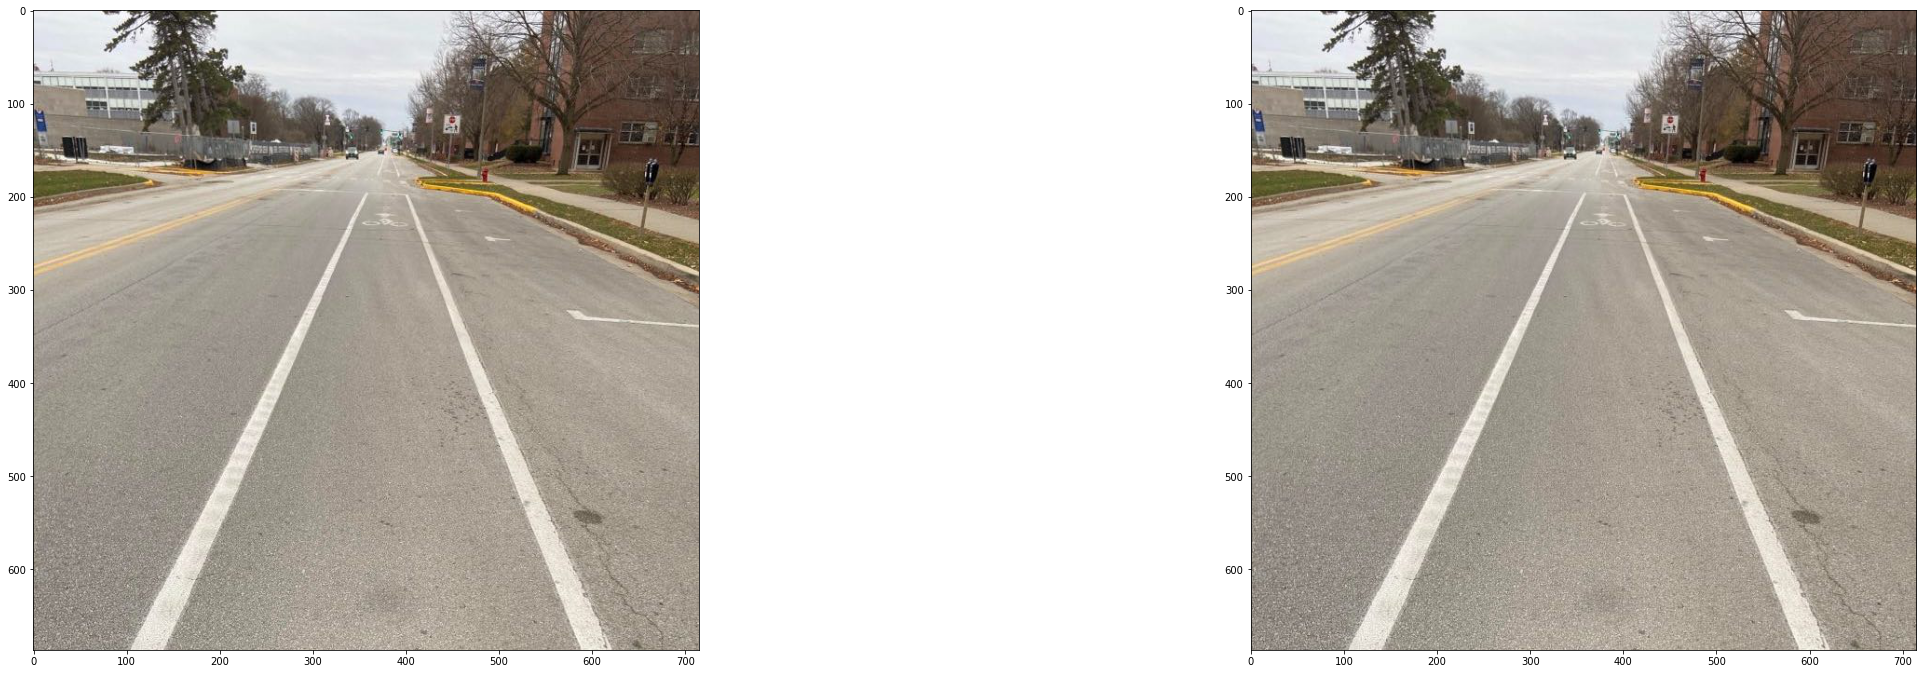

In [ ]:
def show_images(images, cmap=None):
  plt.figure(figsize=(40, 40))
  for i, image in enumerate(images):
    plt.subplot(3, 2, i+1)
    plt.imshow(image, cmap)
    plt.autoscale(tight=True)
  plt.show()

show_images(image_list)

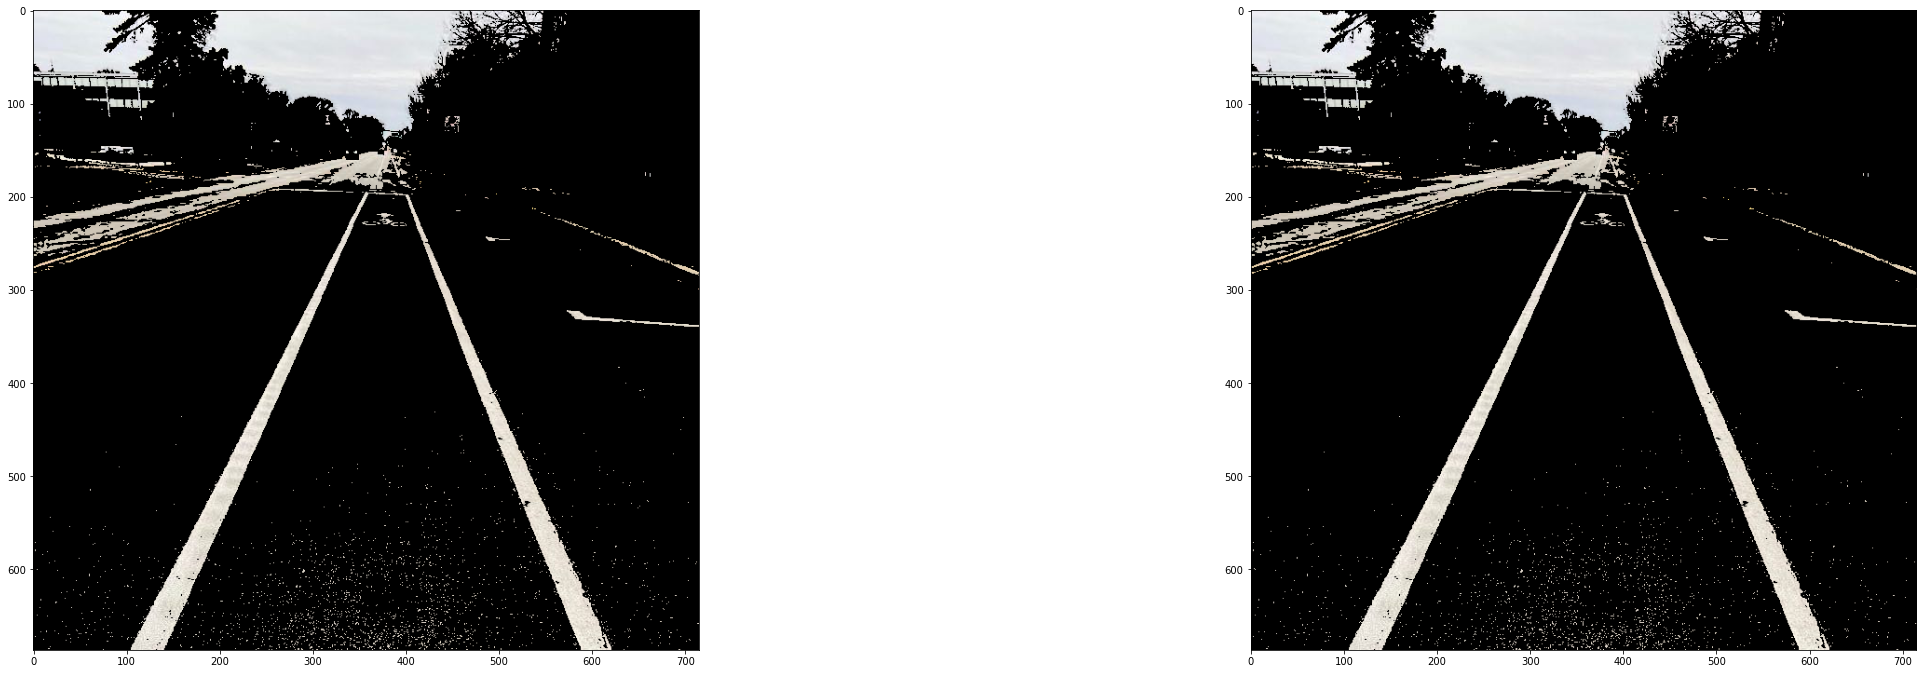

In [ ]:
# mask out unnecessary colors

def color_filter(image):
    #convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])
    
    lower1 = np.array([0,190,0])
    upper2 = np.array([255,255,255])
    
    trans_mask = cv2.inRange(hls, lower1, upper2)    
    whitemask = cv2.inRange(hls, lower, upper)
    
    mask = cv2.bitwise_or(trans_mask, whitemask)  
    masked = cv2.bitwise_and(image, image, mask = mask)    
    


    return masked

filtered_img = list(map(color_filter, image_list))

show_images(filtered_img)

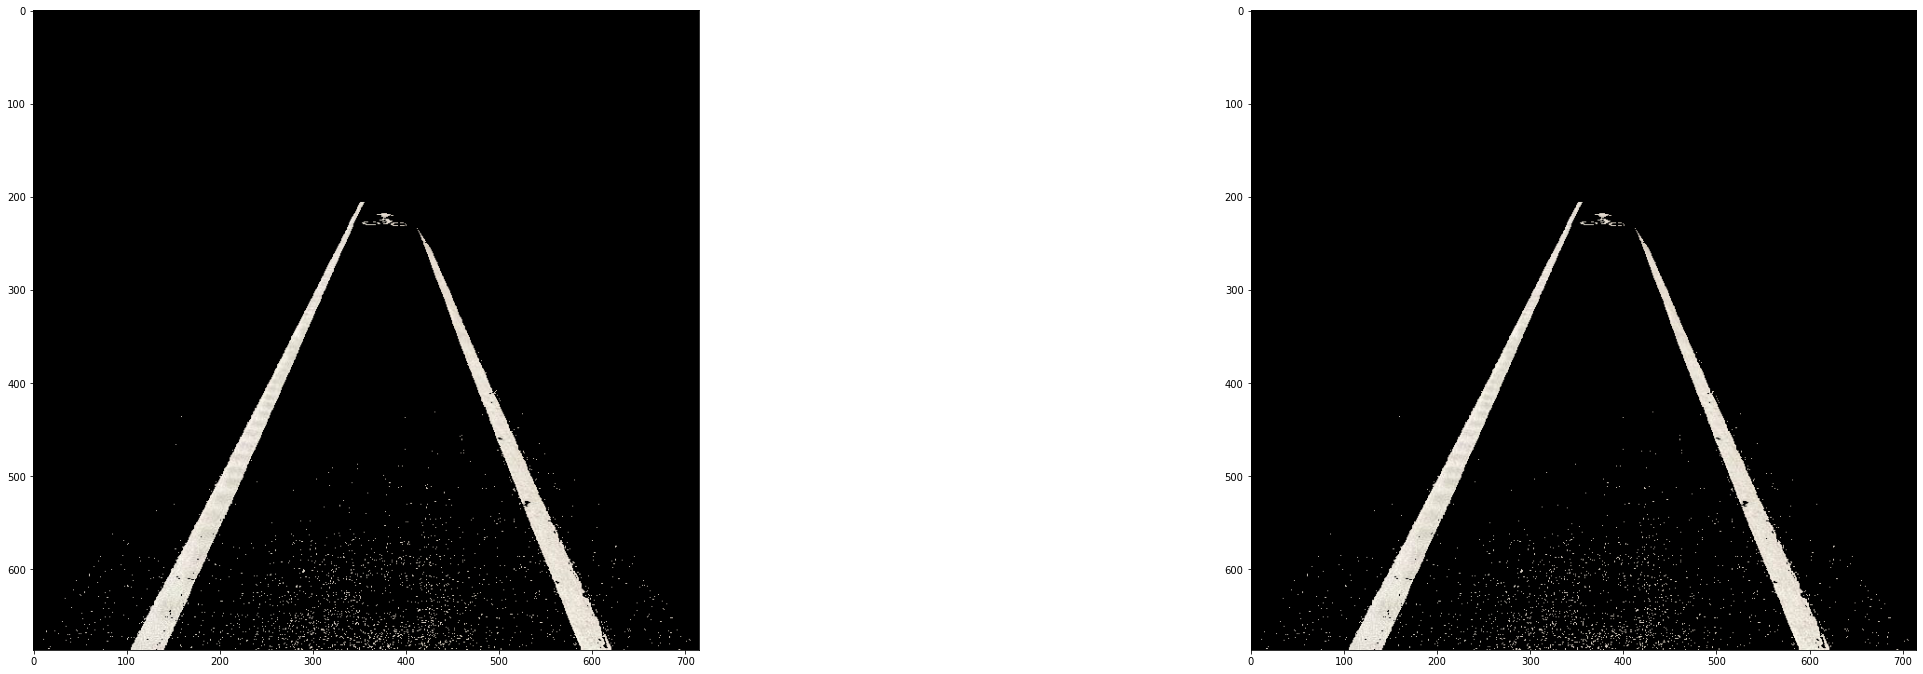

In [ ]:
def region_of_interest(img):
  x = int(img.shape[1])
  y = int(img.shape[0])
  shape = np.array([[int(0), int(y)],
                    [int(x), int(y)], 
                    [int(0.55*x), int(0.3*y)], 
                    [int(0.4*x), int(0.3*y)]])
  
  #define numpy array with the dimensions of img
  mask = np.zeros_like(img)

  #uses 3 channels or 1 channel for color depending on input image

  if len(img.shape) > 2:
    channel_count = img.shape[2]
    ignore_mask_color = (255,) * channel_count
  else:
    ignore_mask_color = 255

  #create a polygon with the mask color
  cv2.fillPoly(mask, np.int32([shape]),
               ignore_mask_color)
  
  #return the image only where the mask pixels are not zero

  masked_image = cv2.bitwise_and(img, mask)
  return masked_image
  
roi_img = list(map(region_of_interest, filtered_img))
show_images(roi_img)

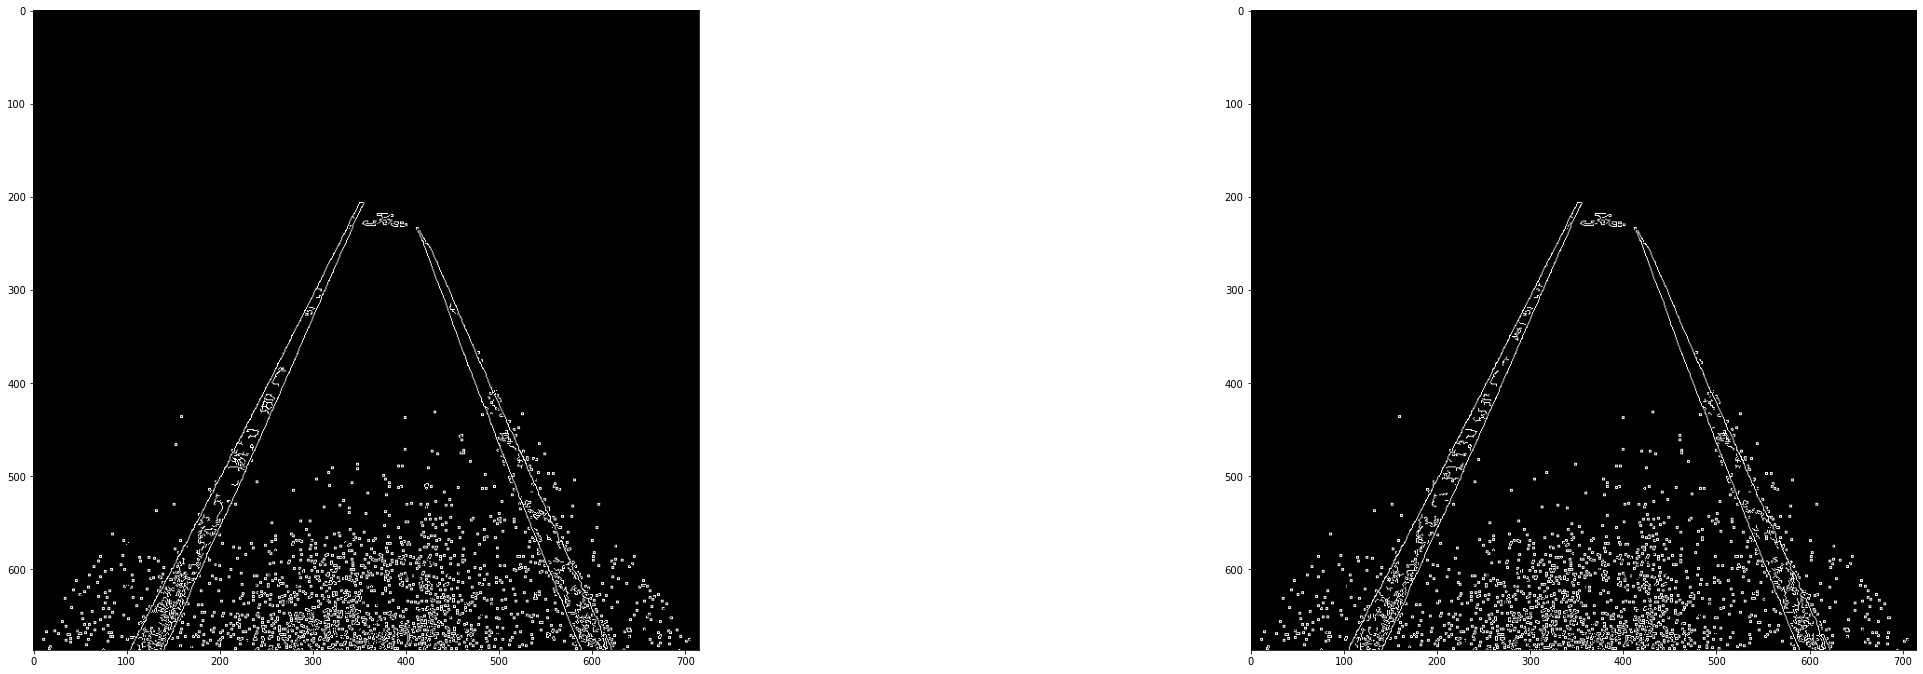

In [ ]:
#Initiate edge detection

def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img):
  return cv2.Canny(grayscale(img), 50, 120)

canny_img = list(map(canny, roi_img))
show_images(canny_img, cmap='gray')

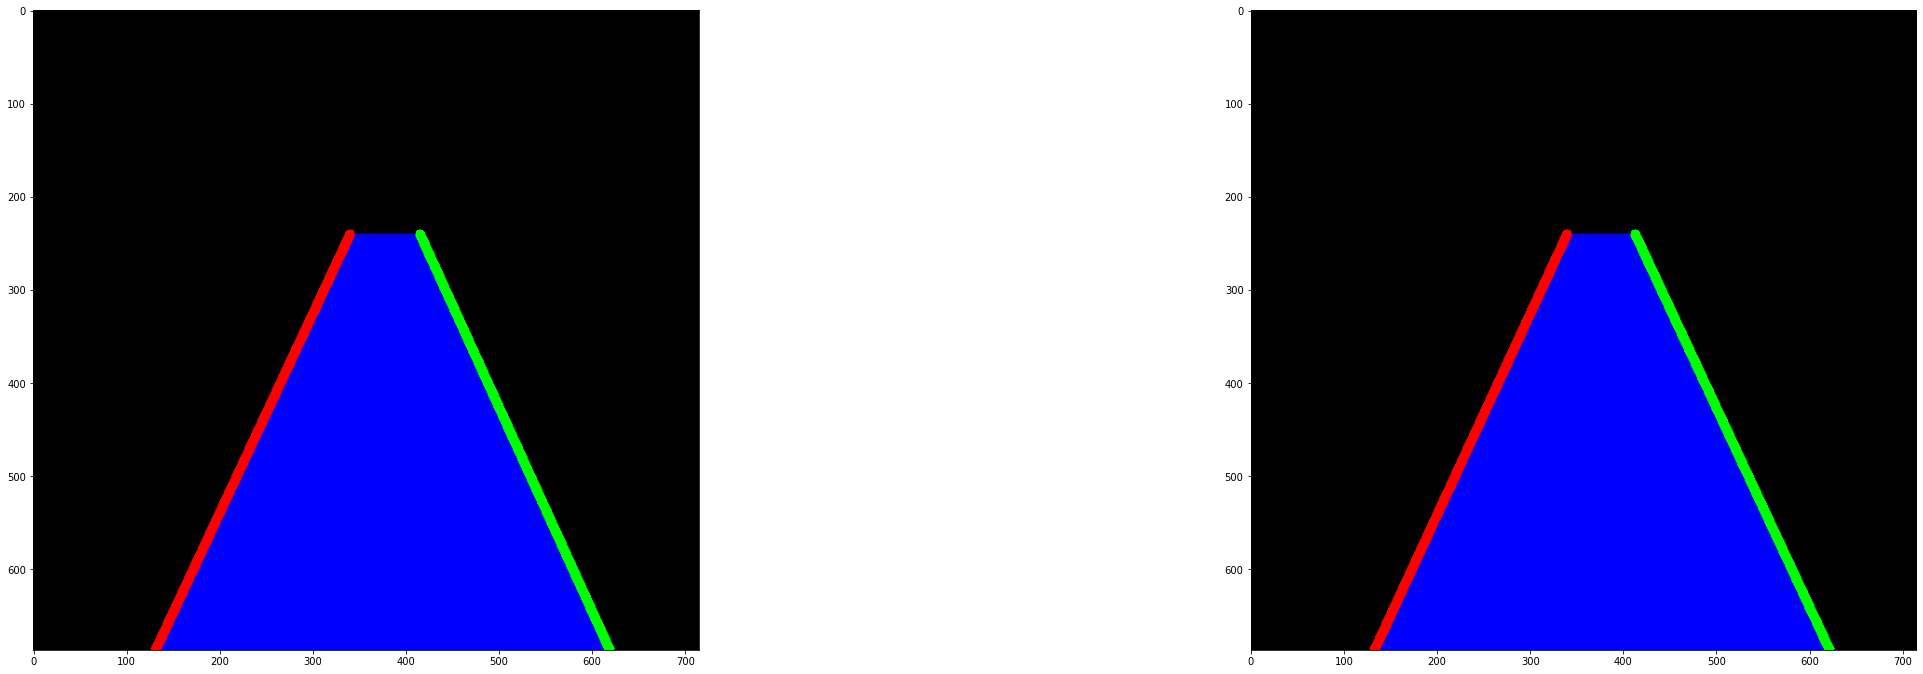

In [ ]:
#Filterout the outlying lines and use the slope to find lines

right_slope, left_slope, right_intercept, left_intercept = [],[],[],[]

def plot_lines(img, lines, thickness=5):
  global right_slope, left_slope, right_intercept, left_intercept
  right_color = [0, 255, 0]
  left_color = [255, 0, 0]

  for line in lines:
    for x1, y1, x2, y2 in line:
      slope = (y1-y2)/(x1-x2)
      if slope > 0.3:
        if x1 > 500:
          yintercept = y2 - (slope*x2)
          right_slope.append(slope)
          right_intercept.append(yintercept)

        else: None
      elif slope < -0.3:
        if x1 < 600:
          yintercept = y2 - (slope*x2)
          left_slope.append(slope)
          left_intercept.append(yintercept)

  # use slicing to find average of 30 previous frames, which makes lanes less likely to shift

  left_avg_slope = np.mean(left_slope[-30:])
  left_avg_intercept = np.mean(left_intercept[-30:])

  right_avg_slope = np.mean(right_slope[-30:])
  right_avg_intercept = np.mean(right_intercept[-30:])

  # plot the lines

  try:
    left_line_x1 = int((0.35*img.shape[0] - left_avg_intercept) / left_avg_slope)
    left_line_x2 = int((img.shape[0] - left_avg_intercept) / left_avg_slope) 

    right_line_x1 = int((0.35*img.shape[0] - right_avg_intercept) / right_avg_slope)
    right_line_x2 = int((img.shape[0] - right_avg_intercept) / right_avg_slope)

    pts = np.array([[left_line_x1, int(0.35*img.shape[0])], [left_line_x2, int(img.shape[0])],
                    [right_line_x2, int(img.shape[0])],[right_line_x1, int(0.35*img.shape[0])]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(img, [pts], (0, 0, 255))

    cv2.line(img, (left_line_x1, int(0.35*img.shape[0])), 
             (left_line_x2, int(img.shape[0])),
             left_color, 10)
    
    cv2.line(img, (right_line_x1, int(0.35*img.shape[0])), 
             (right_line_x2, int(img.shape[0])),
             right_color, 10)
  
  except ValueError:
    pass

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
  lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                          minLineLength=min_line_len, 
                          maxLineGap = max_line_gap)
  line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype= np.uint8)
  plot_lines(line_img, lines)
  return line_img

def line_detect(img):
  return hough_lines(img, 6, np.pi/180,
                     160, 55, 6)
  
hough_img = list(map(line_detect, canny_img))
show_images(hough_img)

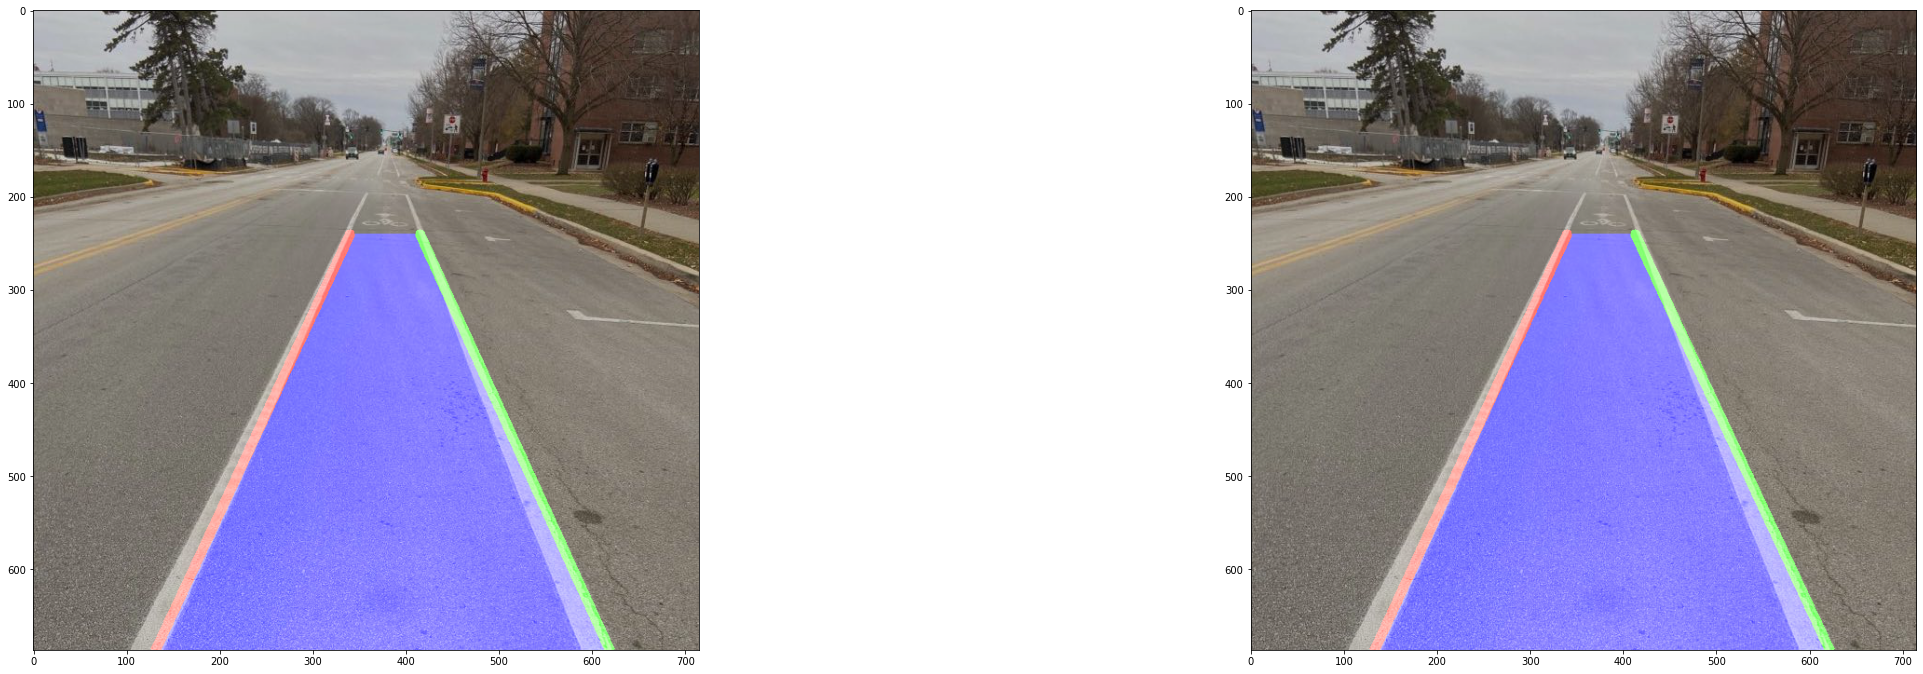

In [ ]:
#plot lines and images together 

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
  return cv2.addWeighted(initial_img, α, img, β, λ)

def weight_sum(input_set):
  img = list(input_set)
  return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

result_img = list(map(weight_sum, zip(hough_img, image_list)))
show_images(result_img)

In [ ]:
def process_img(image):
  interest = region_of_interest(image)
  filtering = color_filter(interest)
  canny = cv2.Canny(grayscale(filtering), 50, 120)
  my_line = hough_lines(canny, 5, np.pi/180, 160, 40, 6)
  weighted_img = cv2.addWeighted(my_line, 1, image, 0.8, 0)
  return weighted_img

In [ ]:
output = 'test_clip2.mp4'
clip = VideoFileClip('test_clip2.mp4').subclip(5, 2)
pclip = clip.fl_image(process_img)
%time pclip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_clip2.mp4
[MoviePy] Writing video test_clip2.mp4


0it [00:00, ?it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_clip2.mp4 

CPU times: user 7.96 ms, sys: 6.25 ms, total: 14.2 ms
Wall time: 33.7 ms
